In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from livelossplot import PlotLossesKerasTF
from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
import keras
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.5.0


In [2]:
import cv2,os

data_path=r'D:\4-1 project\X-Ray Image DataSet'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

{'Covid-19': 0, 'No_findings': 1, 'Pneumonia': 2}
['Covid-19', 'No_findings', 'Pneumonia']
[0, 1, 2]


In [3]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [4]:
import numpy as np

data=np.array(data)/255.0

data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [5]:
width,height,depth=100,100,1
num_classes=3
model=Sequential()

model.add(Conv2D(64,(3,3),input_shape=(width,height,depth)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 50 neurons
model.add(Dense(3,activation='softmax'))
print(model.summary())
model.compile(loss='BinaryCrossentropy',optimizer='adam',metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 128)       0

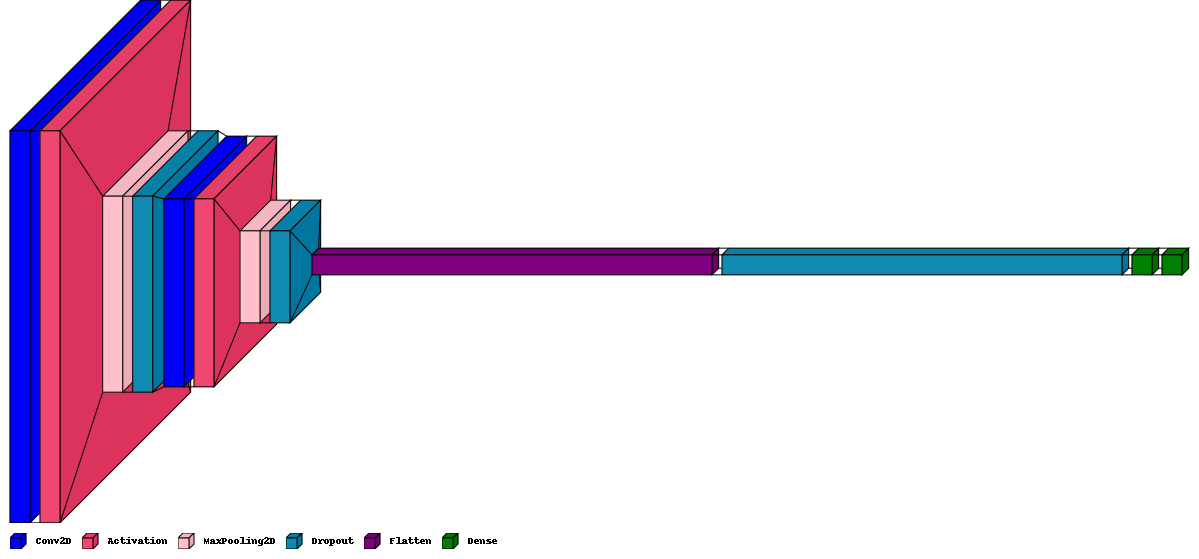

In [6]:
import visualkeras
from collections import defaultdict
from PIL import ImageFont
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'blue'
color_map[MaxPooling2D]['fill'] = 'pink'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'purple'
visualkeras.layered_view(model, legend=True,color_map=color_map) 

In [7]:
# from keras.utils.vis_utils import plot_model
# plot_model(model,to_file=r'D:\pro_out\diabates\model_plot.png',show_shapes=True, show_layer_names=True)

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,new_target,test_size=0.3)

In [9]:
import warnings
warnings.filterwarnings('ignore')
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
checkpoint = ModelCheckpoint('cov-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
h=model.fit(x_train,y_train,epochs=40,validation_split=0.35)

Epoch 1/40
16/16 [==============================] - 9s 514ms/step - loss: 0.7664 - accuracy: 0.4442 - val_loss: 0.5838 - val_accuracy: 0.4275
Epoch 2/40
16/16 [==============================] - 8s 531ms/step - loss: 0.5778 - accuracy: 0.4775 - val_loss: 0.5752 - val_accuracy: 0.4964
Epoch 3/40
16/16 [==============================] - 10s 641ms/step - loss: 0.5398 - accuracy: 0.5597 - val_loss: 0.5118 - val_accuracy: 0.6739
Epoch 4/40
16/16 [==============================] - 9s 580ms/step - loss: 0.4616 - accuracy: 0.6419 - val_loss: 0.4173 - val_accuracy: 0.7464
Epoch 5/40
16/16 [==============================] - 9s 563ms/step - loss: 0.4173 - accuracy: 0.6830 - val_loss: 0.4055 - val_accuracy: 0.7428
Epoch 6/40
16/16 [==============================] - 9s 565ms/step - loss: 0.3749 - accuracy: 0.7515 - val_loss: 0.4033 - val_accuracy: 0.7283
Epoch 7/40
16/16 [==============================] - 8s 494ms/step - loss: 0.3627 - accuracy: 0.7417 - val_loss: 0.3707 - val_accuracy: 0.7645
Epoch

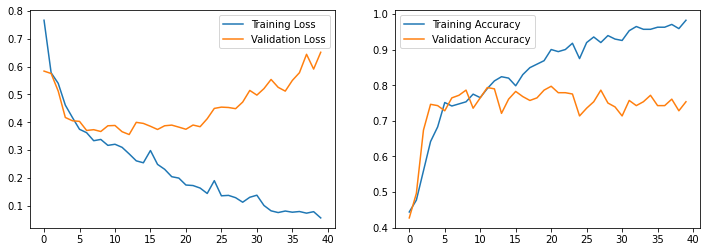

In [12]:
losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [21]:
model=tf.keras.models.load_model('cov-003.model')

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from numpy import asarray
import cv2
img=cv2.imread(r'D:\4-1 project\X-Ray Image DataSet\No_findings\00001769_000.png')
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
resized=cv2.resize(gray,(100,100))
r=resized.reshape(1,100,100,1)
model.predict(r)
a=np.argmax(model.predict(r), axis=1)
a

array([1], dtype=int64)